<a href="https://colab.research.google.com/github/adataschultz/MaritimeTrade_COVID/blob/main/MLP_Regression/MaritimeTradeCOVID_MLP_Train2019_2020_batch32_Epochs50_HPObatch16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
######################################################
#### 2019 - 2020 Maritime Trade with COVID - MLP #####
######################################################

In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Data_MaritimeTrade_MLP/

/content/drive/.shortcut-targets-by-id/1HcYK-ojUTzFDer17GGpL_6eH2GiGvmEK/Data_MaritimeTrade_MLP


In [ ]:
# Install and import packages
!pip install category_encoders
import os
import random
import pandas as pd
import numpy as np
import category_encoders as ce
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
print('\n')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution is: {}".format(tf.executing_eagerly()))
print("Keras version: {}".format(tf.keras.__version__))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

     |████████████████████████████████| 80 kB 5.1 MB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm




TensorFlow version: 2.6.0
Eager execution is: True
Keras version: 2.6.0
Num GPUs Available:  1


In [ ]:
# Reproducibility in TF and Pytorch 
def init_seeds(seed=1920):
    np.random.seed(seed)
    random.seed(seed)
    session_conf = tf.compat.v1.ConfigProto()
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
    os.environ['TF_CUDNN_DETERMINISTIC'] ='true'
    os.environ['TF_DETERMINISTIC_OPS'] = 'true'
    tf.random.set_seed(seed)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(),
                                config=session_conf)
    tf.compat.v1.keras.backend.set_session(sess)
    return sess

In [ ]:
init_seeds(seed=1920)


In [ ]:
df = pd.read_csv('combined_trade_final_LSTM.csv', low_memory=False)
print('Number of rows and columns:', df.shape)

Number of rows and columns: (6633785, 20)


In [ ]:
# Convert dtypes
df = df.copy()
df['State_Closure_EA_Diff'] = df['State_Closure_EA_Diff'].astype('float64')
df['Container_Type_Dry'] = df['Container_Type_Dry'].astype('object')

In [ ]:
df = df.drop(['DateTime'], axis=1)

In [ ]:
# Reformat for X,y
df2 = df.drop(['Metric_Tons'], axis=1)
df1 = df.loc[:, ['Metric_Tons']]
df = pd.concat([df1, df2], axis=1)

del df1, df2

In [ ]:
# X,y for encoding
X = df.drop(['Metric_Tons'], axis=1)
y = df.iloc[:,:1]
print(X.shape)
print(y.shape)

(6633785, 18)
(6633785, 1)


In [ ]:
# Set up train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,
                                                    stratify= X.Year,
                                                    random_state = 1920)

In [ ]:
# Training set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_train = ce_ord.fit_transform(X_train, y_train['Metric_Tons'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Testing set: Encode variables using ranking - ordinal               
ce_ord = ce.OrdinalEncoder(cols = ['foreign_company_size', 'us_company_size'])
X_test = ce_ord.fit_transform(X_test, y_test['Metric_Tons'])

/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# Train: Create dummy variables for categorical variables
X_train = pd.get_dummies(X_train, drop_first=True)
X_train.head()

,TCVUSD,Year,us_company_size,foreign_company_size,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective,Container_LCL/FCL_LCL,Container_Type_Dry_True,Trade_Direction_Import,US_Port_Coastal_Region_Northeast,US_Port_Coastal_Region_Northwest,US_Port_Coastal_Region_Other,US_Port_Coastal_Region_Southeast,US_Port_Coastal_Region_Southwest,Foreign_Country_Region_European Union,Foreign_Country_Region_Middle East & North Africa,Foreign_Country_Region_North America,Foreign_Country_Region_Oceania,Foreign_Country_Region_Other East Asia (not China),Foreign_Country_Region_Other Europe (not European Union),Foreign_Country_Region_South America,Foreign_Country_Region_South Asia,Foreign_Country_Region_Southeast Asia,Foreign_Country_Region_Sub Saharan Africa,HS_Group_Name_Edible with Processing,HS_Group_Name_Finished Goods,HS_Group_Name_Pharma,HS_Group_Name_Raw Input,HS_Group_Name_Vices
1322785,14796.09,2020,1,1,14.8,13.24,242840.0,9105.0,2.0,24283900.0,910400.0,39.0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3187981,25621.34,2019,2,2,4.0,31.79,0.0,0.0,0.0,0.0,0.0,59.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1062127,13326.58,2020,3,3,11.1,3.56,1447771.0,40865.0,0.0,144777000.0,4086400.0,59.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1264197,113.67,2020,3,1,7.8,13.24,4867827.0,96828.0,2.0,486782600.0,9682700.0,39.0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5144839,63815.70,2019,4,3,3.6,11.03,0.0,0.0,2.0,0.0,0.0,27.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
print('Dimensions of X_train for input:', X_train.shape[1])

Dimensions of X_train for input: 35


In [ ]:
# Test: Create dummy variables for categorical variables
X_test = pd.get_dummies(X_test, drop_first=True)
X_test.head()

,TCVUSD,Year,us_company_size,foreign_company_size,US_Unemployment_Rate,Average_Tariff,cases_weekly,deaths_weekly,State_Closure_EA_Diff,cases_pctdelta,deaths_pctdelta,Delta_Case0_Effective,Container_LCL/FCL_LCL,Container_Type_Dry_True,Trade_Direction_Import,US_Port_Coastal_Region_Northeast,US_Port_Coastal_Region_Northwest,US_Port_Coastal_Region_Other,US_Port_Coastal_Region_Southeast,US_Port_Coastal_Region_Southwest,Foreign_Country_Region_European Union,Foreign_Country_Region_Middle East & North Africa,Foreign_Country_Region_North America,Foreign_Country_Region_Oceania,Foreign_Country_Region_Other East Asia (not China),Foreign_Country_Region_Other Europe (not European Union),Foreign_Country_Region_South America,Foreign_Country_Region_South Asia,Foreign_Country_Region_Southeast Asia,Foreign_Country_Region_Sub Saharan Africa,HS_Group_Name_Edible with Processing,HS_Group_Name_Finished Goods,HS_Group_Name_Pharma,HS_Group_Name_Raw Input,HS_Group_Name_Vices
5106325,60440.23,2019,1,1,3.6,2.28,0.0,0.0,2.0,0.0,0.0,27.0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6438450,48273.18,2020,2,2,14.8,18.80,11828.0,245.0,16.0,1182700.0,24400.0,30.0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1831211,26647.72,2020,1,1,8.4,3.56,2969878.0,226578.0,2.0,296987700.0,22657700.0,27.0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3384697,23730.50,2019,1,1,3.7,18.80,0.0,0.0,0.0,0.0,0.0,59.0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1260139,0.00,2020,1,3,6.9,29.76,4980900.0,101462.0,2.0,498089900.0,10146100.0,39.0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


In [ ]:
# MinMax Scaling
mn = MinMaxScaler()
X_train = pd.DataFrame(mn.fit_transform(X_train))
X_test = pd.DataFrame(mn.fit_transform(X_test))

In [ ]:
log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

%load_ext tensorboard

In [ ]:
# Set up callbacks
filepath = 'MLP_weights_only_train1920_b32_epochs50_HPObatch16.h5'

checkpoint_dir = os.path.dirname(filepath)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_folder,
                                                      histogram_freq=1)

callbacks_list = [EarlyStopping(monitor='loss', patience = 5),
                  ModelCheckpoint(filepath, monitor='mse', 
                                  best_model_only = True, mode='min'), 
                  tensorboard_callback]

In [ ]:
# Define model from HPO
# Trial summary
# Hyperparameters:
# num_layers: 4
# layer_size0: 25
# layer_size1: 25
# learning_rate: 0.001
# layer_size2: 25
# layer_size3: 20
# layer_size4: 20
# Score: 11.799287796020508

model = Sequential()
model.add(Dense(25, input_dim=35, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(25, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dense(20, kernel_initializer='normal', activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1))

# Compile model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='mae', metrics=['mse'], optimizer=opt)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                900       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 20)                520       
_________________________________________________________________
dense_4 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2

In [ ]:
# Train the MLP on the train dataset
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_split=0.2, callbacks=callbacks_list)

Epoch 1/50
116092/116092 [==============================] - 283s 2ms/step - loss: 13.0935 - mse: 880.4114 - val_loss: 12.4951 - val_mse: 848.7473
Epoch 2/50
116092/116092 [==============================] - 281s 2ms/step - loss: 12.8498 - mse: 842.2609 - val_loss: 12.4252 - val_mse: 843.1459
Epoch 3/50
116092/116092 [==============================] - 279s 2ms/step - loss: 12.2655 - mse: 768.0217 - val_loss: 11.2672 - val_mse: 664.2846
Epoch 4/50
116092/116092 [==============================] - 280s 2ms/step - loss: 11.5224 - mse: 666.8937 - val_loss: 11.2064 - val_mse: 580.2432
Epoch 5/50
116092/116092 [==============================] - 279s 2ms/step - loss: 11.2815 - mse: 640.0654 - val_loss: 11.0063 - val_mse: 638.7315
Epoch 6/50
116092/116092 [==============================] - 278s 2ms/step - loss: 11.1537 - mse: 627.5007 - val_loss: 10.8688 - val_mse: 618.0255
Epoch 7/50
116092/116092 [==============================] - 277s 2ms/step - loss: 11.0464 - mse: 616.2422 - val_loss: 10.342

In [ ]:
# Save model
model.save('./211010_MLP_batch32_50Epochs_HPObatch16_train1920_tf.h5', save_format='tf')

# Load model for more training or later use
#model = tf.keras.models.load_model('./211010_MLP_batch32_50Epochs_HPObatch16_train1920_tf.h5')

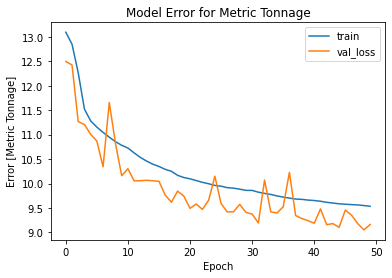

In [ ]:
# Plot loss over epochs
my_dpi = 96
pyplot.title('Model Error for Metric Tonnage')
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.ylabel('Error [Metric Tonnage]')
pyplot.xlabel('Epoch')
pyplot.legend()
pyplot.savefig('Train1920_batch32_50Epochs_HPObatch16_Loss.png', dpi=my_dpi * 10,
               bbox_inches='tight')
pyplot.show()

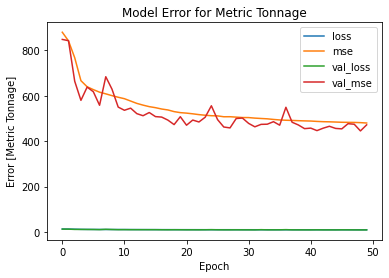

In [ ]:
# Plot loss include loss from validation
losses = pd.DataFrame(model.history.history)
my_dpi = 96
losses.plot()
pyplot.title('Model Error for Metric Tonnage')
pyplot.ylabel('Error [Metric Tonnage]')
pyplot.xlabel('Epoch')
pyplot.savefig('Train1920_batch32_50Epochs_HPObatch16_LossValLoss.png', dpi=my_dpi * 10,
               bbox_inches='tight')

In [ ]:
# Predict on train set
pred_train = model.predict(X_train)

In [ ]:
# Errors in training set
train_error =  np.abs(y_train - pred_train)
mean_error = np.mean(train_error)
print('Train Mean Error:', mean_error)
print('\n')
min_error = np.min(train_error)
print('Train Min Error:', min_error)
print('\n')
max_error = np.max(train_error)
print('Train Max Error:', max_error)
print('\n')
std_error = np.std(train_error)
print('Train Std Error:', std_error)

Train Mean Error: Metric_Tons    9.148594
dtype: float64


Train Min Error: Metric_Tons    0.000001
dtype: float64


Train Max Error: Metric_Tons    308.362278
dtype: float64


Train Std Error: Metric_Tons    19.681198
dtype: float64


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_train)
y_pred.shape

(4643649, 1)

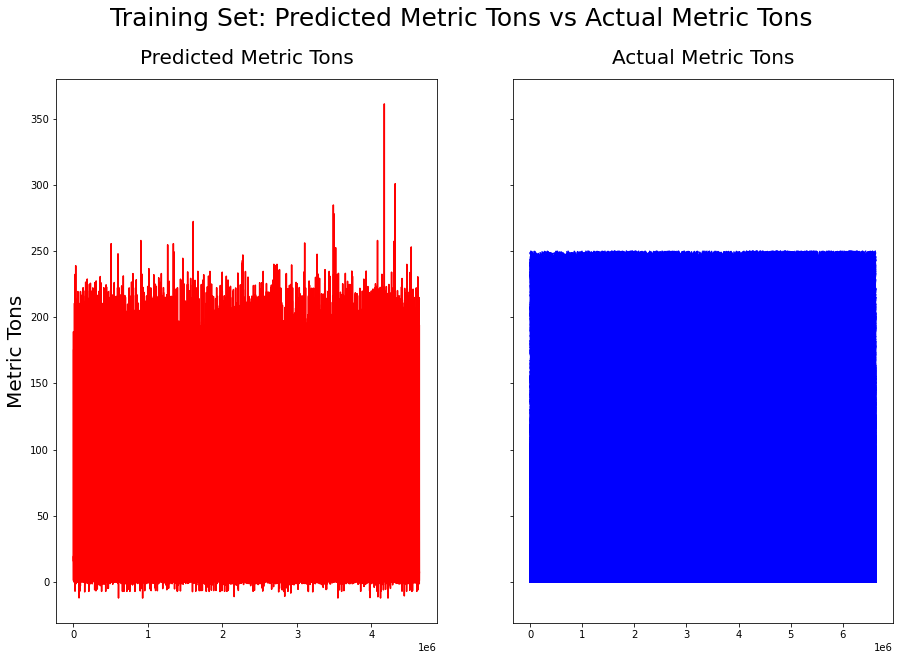

In [ ]:
# Graph predicted vs actual metric tonnage in the test set 
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.pyplot.subplots(1, 2, figsize=(15, 10), sharey=True)
f.suptitle('Training Set: Predicted Metric Tons vs Actual Metric Tons',
           fontsize = 25)
ax1.plot(y_pred, color = 'red')
ax1.set_title('Predicted Metric Tons', pad = 15, fontsize = 20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_train, color = 'blue')
ax2.set_title('Actual Metric Tons', pad = 15, fontsize = 20)
pyplot.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train1920_batch32_50Epochs_HPObatch16_PredictedActual_Train_Side.png',
          dpi=my_dpi, bbox_inches='tight')

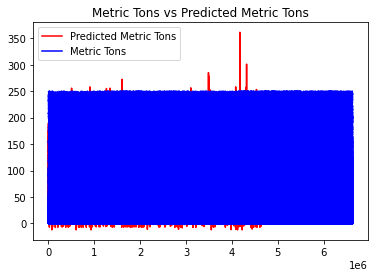

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set 
plt.rcParams['agg.path.chunksize'] = 10000
pyplot.title('Metric Tons vs Predicted Metric Tons')
pyplot.plot(y_pred, color = 'red', label = 'Predicted Metric Tons')
pyplot.plot(y_train, color = 'blue', label = 'Metric Tons')
pyplot.legend()
pyplot.savefig('Train1920_batch32_50Epochs_HPObatch16_PredictedActual_Train_Overlaid.png',
               dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [ ]:
# Predict on test set
pred_test = model.predict(X_test)

In [ ]:
# Errors in test set
test_error =  np.abs(y_test - pred_test)
mean_error = np.mean(test_error)
print('Test Mean Error:', mean_error)
print('\n')
min_error = np.min(test_error)
print('Test Min Error:', min_error)
print('\n')
max_error = np.max(test_error)
print('Test Max Error:', max_error)
print('\n')
std_error = np.std(test_error)
print('Test Std Error:', std_error)

Test Mean Error: Metric_Tons    10.600147
dtype: float64


Test Min Error: Metric_Tons    0.000007
dtype: float64


Test Max Error: Metric_Tons    378.050452
dtype: float64


Test Std Error: Metric_Tons    21.226999
dtype: float64


In [ ]:
# Convert predicted metric tons to data frame
y_pred = pd.DataFrame(pred_test)
y_pred.shape

(1990136, 1)

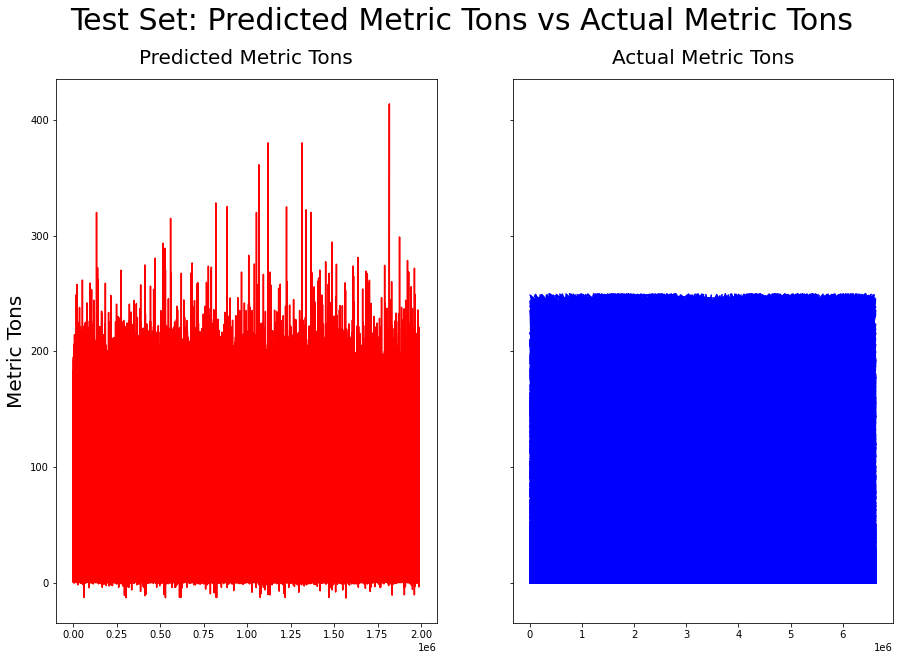

In [ ]:
# Graph predicted vs actual metric tonnage in the test set 
plt.rcParams['agg.path.chunksize'] = 10000
f, ((ax1), (ax2)) = plt.pyplot.subplots(1, 2, figsize=(15, 10), sharey=True)
f.suptitle('Test Set: Predicted Metric Tons vs Actual Metric Tons', fontsize = 30)
ax1.plot(y_pred, color = 'red')
ax1.set_title('Predicted Metric Tons', pad = 15, fontsize = 20)
ax1.set_ylabel('Metric Tons', fontsize=20)
ax2.plot(y_test, color = 'blue')
ax2.set_title('Actual Metric Tons', pad = 15, fontsize = 20)
pyplot.show()

In [ ]:
# Save file separately due "OverflowError: In draw_path: Exceeded cell block limit"
f.savefig('Train1920_batch32_50Epochs_HPObatch16_PredictedActual_Test_Side.png',
          dpi=my_dpi, bbox_inches='tight')

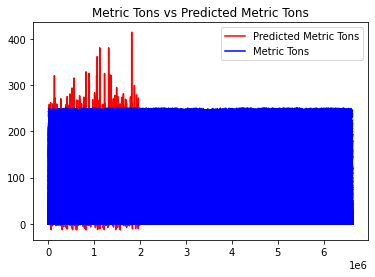

In [ ]:
# Graph overlaid predicted vs actual metric tonnage in the test set 
plt.rcParams['agg.path.chunksize'] = 10000
pyplot.title('Metric Tons vs Predicted Metric Tons')
pyplot.plot(y_pred, color = 'red', label = 'Predicted Metric Tons')
pyplot.plot(y_test, color = 'blue', label = 'Metric Tons')
pyplot.legend()
pyplot.savefig('Train1920_batch32_50Epochs_HPObatch16_PredictedActual_Test_Overlaid.png',
               dpi=my_dpi * 10, bbox_inches='tight')
pyplot.show()

In [ ]:
# Metrics from training model 
print('Train Mean Absolute Error (MAE):', mean_absolute_error(y_train[:], pred_train[:]))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(y_train[:], pred_train[:]))
print('Train Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_train[:], pred_train[:])))

Train Mean Absolute Error (MAE): 9.148594360546472
Mean Square Error (MSE): 471.046347
Train Root Mean Squared Error (RMSE): 21.703602174745747


In [ ]:
# Metrics from test set 
print('Test Mean Absolute Error (MAE):', mean_absolute_error(y_test[:], pred_test[:]))
print('Mean Square Error (MSE): %3f' % sklearn.metrics.mean_squared_error(y_test[:], pred_test[:]))
print('Test Root Mean Squared Error (RMSE):', np.sqrt(mean_squared_error(y_test[:], pred_test[:])))

Test Mean Absolute Error (MAE): 10.600146927811833
Mean Square Error (MSE): 562.948599
Test Root Mean Squared Error (RMSE): 23.7265378711834


In [ ]:
# Predicted maximum, average and minimum metric tonnage
print("Predicted Max Metric Tons")
print(np.amax(pred_test))
("\n")
print("Predicted Average Metric Tons")
print(np.average(pred_test))
("\n")
print("Predicted Minimum Metric Tons")
print(np.amin(pred_test))

Predicted Max Metric Tons
414.15045
Predicted Average Metric Tons
20.415195
Predicted Minimum Metric Tons
-13.292933


In [ ]:
# Maxmimum, average and minimum real metric tonnage
print("Maximum Metric Tons")
print(np.amax(y_test))
("\n")
print("Average Metric Tons")
print(np.average(y_test))
("\n")
print("Minimum Metric Tons")
print(np.amin(y_test))

Maximum Metric Tons
Metric_Tons    249.99
dtype: float64
Average Metric Tons
21.719979016509416
Minimum Metric Tons
Metric_Tons    0.0
dtype: float64
